In [1]:
%matplotlib notebook
import numpy as np
import ase.db
import numpy.linalg as la
import scipy.stats as ss
import scipy as sp
from statistics import mean
import matplotlib.pyplot as plt
import seaborn as sns
#plt.style.use('notestyle')

In [2]:
dbase = ase.db.connect('cubic_perovskites.db')
syss=[c for c in dbase.select() if not hasattr(c,"reference")]

In [3]:
len(syss)

18928

In [4]:
syss[0]._keys

['project',
 'A_ion',
 'anion',
 'combination',
 'CB_ind',
 'gllbsc_ind_gap',
 'heat_of_formation_all',
 'CB_dir',
 'gllbsc_dir_gap',
 'standard_energy',
 'B_ion',
 'VB_dir',
 'VB_ind']

In [5]:
Aset=set()
Bset=set()
anionset=set()
for p in syss:
    Aset.add(p.A_ion)
    Bset.add(p.B_ion)
    anionset.add(p.anion)
Alist=list(Aset)
Alist.sort()
Blist=list(Bset)
Blist.sort()
anionlist=list(anionset)
anionlist.sort()

In [6]:
# Anions: O,N,S,F
aniondict={'N3':[0,3,0,0],'O2F':[2,0,0,1], 'O2N':[2,1,0,0], 'O2S':[2,0,1,0],'O3':[3,0,0,0], 'OFN':[1,1,0,1],'ON2':[1,2,0,0]}

In [23]:
elemdict={'Ag':[5,11],
          'Al':[3,13],
          'As':[4,15],
          'Au':[6,11],
          'B':[2,13],
          'Ba':[6,2],
          'Be':[2,2],
          'Bi':[6,15],
          'Ca':[4,2],
          'Cd':[5,12],
          'Co':[4,9],
          'Cr':[4,6],
          'Cs':[6,1],
          'Cu':[4,11],
          'Fe':[4,8],
          'Ga':[4,13],
          'Ge':[4,14],
          'Hf':[6,4],
          'Hg':[6,12],
          'In':[5,13],
          'Ir':[6,9],
          'K':[4,1],
          'La':[6,2.5],
          'Li':[2,1],
          'Mg':[3,2],
          'Mn':[4,7],
          'Mo':[5,6],
          'Na':[3,1],
          'Nb':[5,5],
          'Ni':[4,10],
          'Os':[6,8],
          'Pb':[6,14],
          'Pd':[5,10],
          'Pt':[6,10],
          'Rb':[5,1],
          'Re':[6,7],
          'Rh':[5,9],
          'Ru':[5,8],
          'Sb':[5,15],
          'Sc':[4,3],
          'Si':[3,14],
          'Sn':[5,14],
          'Sr':[5,2],
          'Ta':[6,5],
          'Te':[5,16],
          'Ti':[4,4],
          'Tl':[6,13],
          'V':[4,5],
          'W':[6,6],
          'Y':[5,3],
          'Zn':[4,12],
          'Zr':[5,4]}

In [22]:
def finger(s):
    return np.concatenate([elemdict[s.A_ion],elemdict[s.B_ion],np.asarray(aniondict[s.anion])])


### Determine the hyperparameters $\ell$ and $k_0$.

In [13]:
sigma = 0.003

In [26]:
nt=500
np.random.seed(seed=42)
trainsyss=np.random.choice(syss,nt,replace=False)
trainfingers=np.asarray([finger(sys) for sys in trainsyss])  #train data
print(trainfingers)
traindists = np.array([[sum((t1-t2)**2) for t1 in trainfingers] for t2 in trainfingers])
print('---------------')
print(traindists)

[[ 6.  6.  6. ...  1.  0.  0.]
 [ 4. 12.  4. ...  2.  0.  0.]
 [ 4.  3.  5. ...  0.  0.  1.]
 ...
 [ 5. 11.  4. ...  3.  0.  0.]
 [ 4.  1.  5. ...  1.  0.  1.]
 [ 4.  3.  6. ...  3.  0.  0.]]
---------------
[[  0.  47.  32. ...  42.  32.  57.]
 [ 47.   0. 113. ...  13. 125. 112.]
 [ 32. 113.   0. ...  84.  22. 115.]
 ...
 [ 42.  13.  84. ...   0. 112. 133.]
 [ 32. 125.  22. ... 112.   0.  47.]
 [ 57. 112. 115. ... 133.  47.   0.]]


In [10]:
trainval=np.asarray([sys.heat_of_formation_all for sys in trainsyss])  #train value(y)
trainmean=mean(trainval)
trainval-=trainmean

In [11]:
def minuslogP(length):
    C0 = np.exp(-traindists/(2*length**2))
    C0inv = np.linalg.inv(C0)
    C0invt = np.dot(C0inv,trainval)
    k0 = np.dot(trainval,C0invt)/nt
    C = k0*C0
    Cinvt = C0invt/k0
    return 0.5*np.sum(np.log(np.linalg.eigvals(C)))+0.5*np.dot(trainval,Cinvt)

<IPython.core.display.Javascript object>


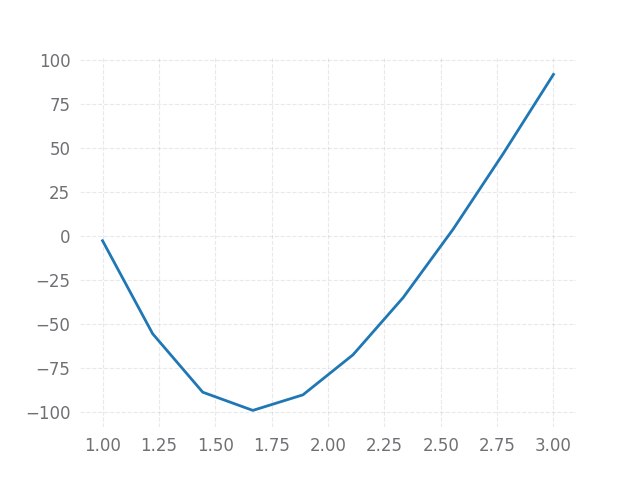

In [12]:
lgrid = np.linspace(1,3,10)
lpgrid = np.array([minuslogP(ll)  for ll in lgrid])
plt.figure()
plt.plot(lgrid,lpgrid)

In [13]:
sp.optimize.minimize(minuslogP,1.7,bounds=[(1.3,2.)]) #,bounds=sp.optimize.Bounds(1.,3.))

      fun: -98.9397607732933
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.1159077e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 12
      nit: 4
   status: 0
  success: True
        x: array([1.66509043])

#### Determination of $k_0$.

In [14]:
ll=1.67
C0 = np.exp(-traindists/(2*ll**2))
k0 = np.dot(trainval,np.linalg.solve(C0,trainval))/nt
print(k0)

0.5154092945860415


### Training

In [27]:
sigma = 0.003
ll = 1.67
k0 = 0.515
def kernel(f1,f2):
    return k0*np.exp(-sum((f1-f2)**2)/(2*ll**2))

In [28]:
nt = 500
np.random.seed(seed=42)
trainsyss=np.random.choice(syss,nt,replace=False)   
testsyss=[sys for sys in syss if sys not in trainsyss]  
trainfingers=np.asarray([finger(sys) for sys in trainsyss]) #train data
testfingers=np.asarray([finger(sys) for sys in testsyss]) #test data
traindists = np.array([[sum((t1-t2)**2) for t1 in trainfingers] for t2 in trainfingers])

In [29]:
trainval=np.asarray([sys.heat_of_formation_all for sys in trainsyss]) #train value (y)
trainmean=mean(trainval)
trainval-=trainmean
testval=[sys.heat_of_formation_all for sys in testsyss]

In [30]:
K = np.asarray([[kernel(t1,t2) for t1 in trainfingers] for t2 in trainfingers])
C = K + k0*sigma**2*np.identity(nt)
Cinv = np.linalg.inv(C)
Cinvt = np.linalg.solve(C,trainval)

### Prediction

In [31]:
def predict(fp):
    kkk = np.array([kernel(fp,fpp) for fpp in trainfingers])
    return np.dot(kkk,Cinvt)+trainmean
    
def error_predict(fp):
    kkk = np.array([kernel(fp,fpp) for fpp in trainfingers])
    return np.sqrt(k0 - np.dot(kkk,np.dot(Cinv,kkk)))

In [32]:
testpred = np.array([predict(fp) for fp in testfingers])
errorpred = np.array([error_predict(fp) for fp in testfingers])

In [33]:
print(mean(np.abs(testpred-testval)),mean(abs(errorpred)),np.sqrt(mean((testpred-testval)**2)),np.sqrt(mean(errorpred**2)))

0.29474938378255855 0.40089861718888725 0.41313222647955067 0.4126951039648965


<IPython.core.display.Javascript object>


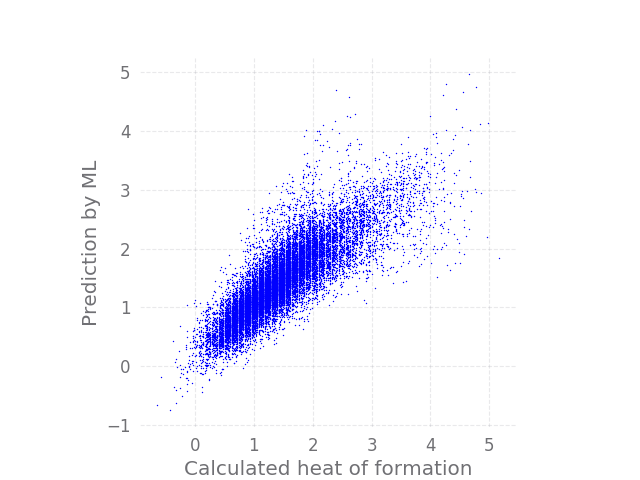

In [33]:
fig, ax = plt.subplots()
ax.plot(testval,testpred,'.',markersize=2, mew= 0,color='b')
#axis([-1,1,-1,1])
ax.set_xlabel('Calculated heat of formation',size='x-large')
ax.set_ylabel('Prediction by ML',size='x-large')
ax.set_aspect('equal')
plt.show()
#plt.savefig('MLcomparison.pdf')

<IPython.core.display.Javascript object>


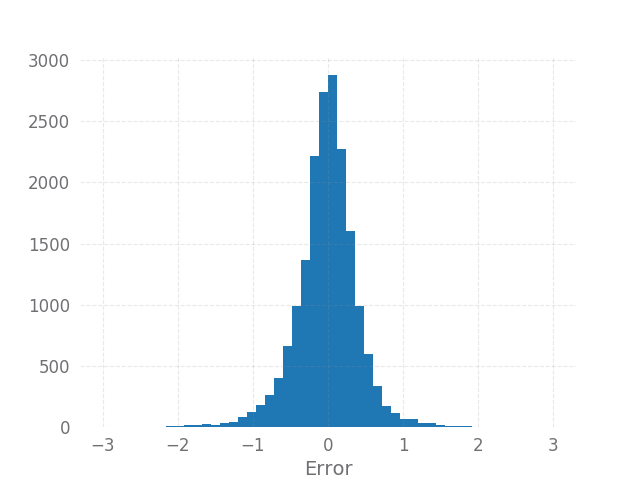

In [35]:
fig, ax = plt.subplots()
hh=ax.hist((testpred-testval),bins=50,range=[-3,3])
ax.set_xlabel('Error')
plt.show()
plt.savefig('error.pdf')

<IPython.core.display.Javascript object>


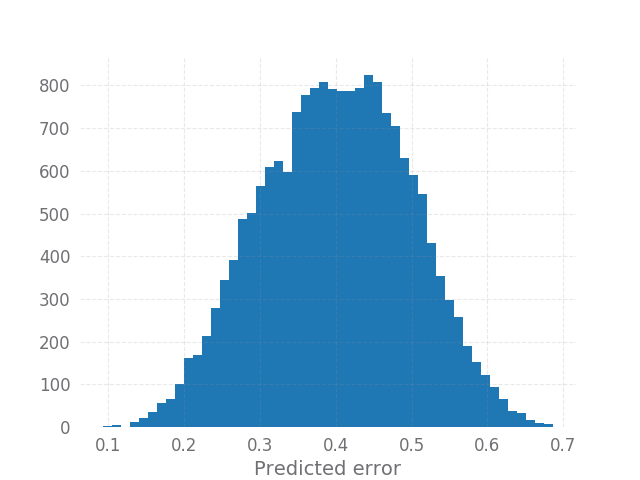

In [36]:
fig, ax = plt.subplots()
hh=ax.hist(errorpred,bins=50)
ax.set_xlabel('Predicted error')
plt.show()

<IPython.core.display.Javascript object>


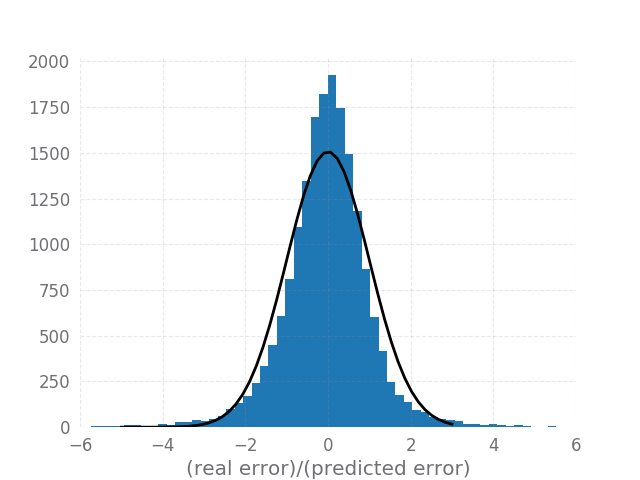

In [39]:
def gaussian(x):
    return 1./np.sqrt(2*np.pi)*np.exp(-x**2/2)
ttt=(testpred-testval)/errorpred
xmin=min(ttt)
xmax=max(ttt)
bins=100
fig,ax = plt.subplots()
hhh=ax.hist(ttt,bins=bins)
xxx=np.linspace(-5,3)
ax.plot(xxx,len(ttt)/bins*(xmax-xmin)*gaussian(xxx),lw=2,color = 'k')
ax.set_xlabel('(real error)/(predicted error)', size='x-large')
ax.set_xlim([-6,6])
plt.show()
#plt.savefig('error_ratio.pdf')